In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error

In [ ]:
train_for = 735
predict_for = 14

In [ ]:
look_back = 50

def prepare_data(df):
    X = []
    y = []
    for i in range(look_back, len(df)):
        y.append(df[i])
        X.append(df[i - look_back:i])
    return np.array(X), np.array(y)

In [ ]:
class Model:
  def __init__(self, df, epochs = 100):
    self.df = scale(df)
    self.dfw, self.dfy = prepare_data(self.df)
    self.epochs = epochs

    self.model_strong = Sequential()
    self.model_strong.add(LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)))
    self.model_strong.add(LSTM(units = 32, return_sequences=True))
    self.model_strong.add(LSTM(units = 32))
    self.model_strong.add(Dense(units = 1))  #our predictions
    # self.model_strong.compile(optimizer = 'adam', loss = tf.keras.losses.CosineSimilarity(axis=1))
    self.model_strong.compile(optimizer = 'adam', loss = 'mean_squared_error')




    self.model_weak = Sequential()

    self.model_weak.add(LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)))
    self.model_weak.add(Dropout(0.2))
    self.model_weak.add(LSTM(units = 32, return_sequences=True))
    self.model_weak.add(Dropout(0.2))
    self.model_weak.add(LSTM(units = 32))
    self.model_weak.add(Dropout(0.2))
    self.model_weak.add(Dense(units = 1))  #our predictions
    # self.model_weak.compile(optimizer = 'adam', loss = tf.keras.losses.CosineSimilarity(axis=1))
    self.model_weak.compile(optimizer = 'adam', loss = 'mean_squared_error')

  def fit(self):
    y_train_strong = self.dfy / 4
    y_train_weak = self.dfy - y_train_strong
    # training the strong model for more epochs
    self.model_strong.fit(self.dfw, y_train_strong, epochs = 7)
    # training the weak model for less epochs
    self.model_weak.fit(self.dfw, y_train_weak, epochs = 3)
  
  def predict(self, predict_for):
    df_full = self.dfw[-1]

    X_p_strong = [df_full]
    X_p_weak = [df_full]
    y_p_strong = []
    y_p_weak = []

    for i in range(predict_for):
        yi_strong = self.model_strong.predict(np.array(X_p_strong))
        y_p_strong.append(yi_strong[0][0])
        yi_weak = self.model_weak.predict(np.array(X_p_weak))
        y_p_weak.append(yi_weak[0][0])
        X_p_strong = [np.append(X_p_strong[0][1:], yi_strong)]
        X_p_weak = [np.append(X_p_weak[0][1:], yi_weak)]
    y_p = [0 for y_p_i in range(len(y_p_strong))]
    for j in range(len(y_p)):
        y_p[j] = y_p_strong[j] + y_p_weak[j]
    return y_p

In [ ]:
scaler = MinMaxScaler()
def scale(df):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.fit_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

def descaled(df):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.inverse_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
df=df.groupby(['Date']).agg({'F_pos': 'sum', 'M_pos': 'sum', 'T_pos':'sum', 'NIA_pos':'sum', 'new_case': 'sum'}).reset_index()

date = df.iloc[train_for + 1]['Date']

df_f = df['F_pos'].values
df_m = df['M_pos'].values
df_t = df['T_pos'].values
df_nia = df['NIA_pos'].values

df = df_f + df_m + df_t + df_nia

In [ ]:
def smoothen_freq(df):
  x = df
  nan_indices = np.isnan(x)

  # # Remove the NaN values from the array
  x = x[np.logical_not(nan_indices)]

  # Generate a noisy signal
  signal = x

  # Apply Fourier transform to the signal
  f_signal = np.fft.fft(signal)

  # Calculate the power spectrum
  power = np.abs(f_signal)**2

  # Set a threshold to remove the noise
  threshold = 0.005 * max(power)
  f_signal[power < threshold] = 0

  # Apply inverse Fourier transform to the filtered signal
  filtered_signal = np.fft.ifft(f_signal)

  return filtered_signal

In [ ]:
# df = smoothen(df, 3)

In [ ]:
df_train = df[:train_for]
df_test = df[train_for:train_for+predict_for]

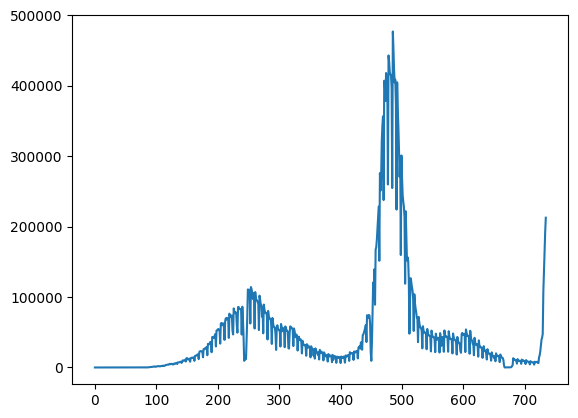

In [ ]:
plt.plot(df_train)

In [ ]:
model = Model(np.array(df_train))
model.fit()

Epoch 1/7
22/22 [==============================] - 9s 111ms/step - loss: 4.6293e-04
Epoch 2/7
22/22 [==============================] - 2s 96ms/step - loss: 3.0276e-04
Epoch 3/7
22/22 [==============================] - 1s 67ms/step - loss: 2.1939e-04
Epoch 4/7
22/22 [==============================] - 1s 67ms/step - loss: 1.9605e-04
Epoch 5/7
22/22 [==============================] - 2s 69ms/step - loss: 1.7166e-04
Epoch 6/7
22/22 [==============================] - 2s 68ms/step - loss: 1.7771e-04
Epoch 7/7
22/22 [==============================] - 2s 68ms/step - loss: 1.7168e-04
Epoch 1/3
22/22 [==============================] - 9s 101ms/step - loss: 0.0082
Epoch 2/3
22/22 [==============================] - 2s 103ms/step - loss: 0.0043
Epoch 3/3
22/22 [==============================] - 2s 71ms/step - loss: 0.0038


In [ ]:
model.model_weak.save("model_weak.h5")
model.model_strong.save("model_strong.h5")

In [ ]:
y_pred = model.predict(predict_for)

1/1 [==============================] - 0s 27ms/step


In [ ]:
y_pred1 = descaled(y_pred)


y_test = df_test


def mape_(p, a):
  m = 0.0
  for i in range(len(p)):
    if (a[i] == 0):
      a[i] = 1
    m += abs(p[i] - a[i]) / a[i]
  return( m / len(p)) * 100




print(mape_(y_pred1, y_test))

60.989109550213314


In [ ]:
# print(y_pred1)

In [ ]:
# print(y_test)

In [ ]:
# dot_img_file = '/model_strong.png'
# tf.keras.utils.plot_model(model.model_strong, to_file=dot_img_file, show_shapes=True)

In [ ]:
# dot_img_file = '/model_weak.png'
# tf.keras.utils.plot_model(model.model_weak, to_file=dot_img_file, show_shapes=True)

In [ ]:
predictions = y_pred1
actual = y_test

In [ ]:
import matplotlib.pyplot as plt
def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

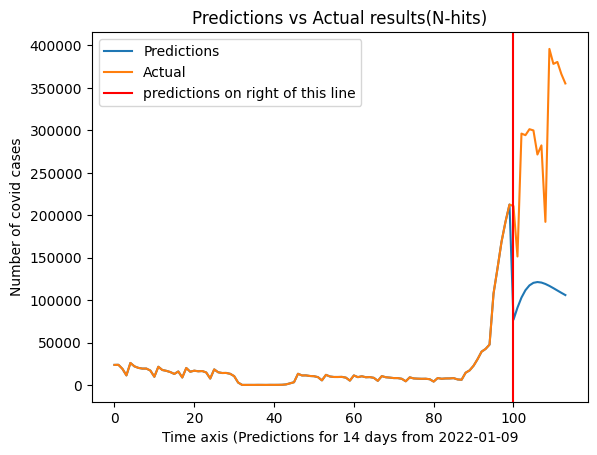

In [ ]:
window = 100
plt.figure()
plt.title("Predictions vs Actual results(N-hits)")
plt.plot(append(df[train_for - window:train_for], predictions), label="Predictions")
plt.plot(append(df[train_for - window:train_for], actual), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
print(predictions)

[ 76864.46   91131.664 102963.33  111685.29  117347.305 120362.88
 121286.99  120676.92  119024.81  116729.36  114092.914 111331.21
 108586.12  105947.78 ]


In [ ]:
print(actual)

[210776. 151380. 296174. 294333. 301381. 299915. 271531. 282285. 192189.
 395946. 378298. 380601. 366328. 355254.]
